In [133]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
import re
import scipy.stats
from math import sqrt


The assessment will guide you to critically investigate the resilience of the London’s underground as a network and the methodological limitations. You will do this in two ways. In the first part, you will only take into consideration the infrastructural network, where stations are connected through only one link, regardless of the number of lines connecting the stations. In the second part, you will consider the commuting flows, and discuss the impact of the analysis on the number of people moving from one part of the city to another. Then, you will recompute the flows using spatial interaction models according to different scenarios described below and discuss the vulnerability of the network under these new scenarios.    

# Part 1: London’s underground resilience: 50 marks

## I. Topological network: 34 marks

In [134]:
# G = nx.read_graphml('./data/london_tubenetwork.graphml')
df_csv = pd.read_csv('./data/london_flows.csv')
scaler = MinMaxScaler() 
df_csv['flows_normalized'] = scaler.fit_transform(df_csv[['flows']])

G = nx.Graph()
for i, row in df_csv.iterrows():
    station1 = row['station_origin']
    station2 = row['station_destination']
    flows = row['flows']
    population = row['population']
    jobs = row['jobs']
    distance = row['distance']
    flows_normalized = row['flows_normalized']

    # make 0 as 0.01
    if flows == 0:
        flows = 0.01
    if flows_normalized == 0:
        flows_normalized = 0.0000001
    if population == 0:
        population = 0.01
    if jobs == 0:
        jobs = 0.01

    flows_weight = 1/flows
    flows_normalized_weight = 1 - flows_normalized

    if station1 not in G.nodes:
        G.add_node(station1, station_name = station1)
    if station2 not in G.nodes:
        G.add_node(station2, station_name = station2)
    G.add_edge(station1, station2, flows=flows, flows_weight=flows_weight, 
               flows_normalized=flows_normalized, flows_normalized_weight=flows_normalized_weight, 
               distance=distance, population=population, jobs=jobs)

In [135]:
# show the detail 
df = nx.to_pandas_edgelist(G)
df.head(10)

,source,target,flows_normalized,flows_normalized_weight,population,jobs,flows,distance,flows_weight
0,Abbey Road,Bank and Monument,1.000000e-07,1.000000,29494.0,345.0,0.01,8131.525097,100.0
1,Abbey Road,Beckton,1.000000e-07,1.000000,1179.0,345.0,0.01,8510.121774,100.0
2,Abbey Road,Blackwall,1.000000e-07,1.000000,952.0,345.0,0.01,3775.448872,100.0
3,Abbey Road,Canary Wharf,1.254233e-04,0.999875,14632.0,345.0,2.00,5086.514220,0.5
4,Abbey Road,Canning Town,3.135583e-04,0.999686,21125.0,345.0,5.00,2228.923167,0.2
5,Abbey Road,Crossharbour,1.000000e-07,1.000000,1724.0,345.0,0.01,6686.475560,100.0
6,Abbey Road,Custom House,1.000000e-07,1.000000,599.0,845.0,0.01,3824.855630,100.0
7,Abbey Road,Cutty Sark,1.000000e-07,1.000000,2122.0,345.0,0.01,8503.898909,100.0
8,Abbey Road,Cyprus,1.000000e-07,1.000000,500.0,345.0,0.01,6532.099618,100.0
9,Abbey Road,Devons Road,1.000000e-07,1.000000,1387.0,345.0,0.01,3958.324171,100.0


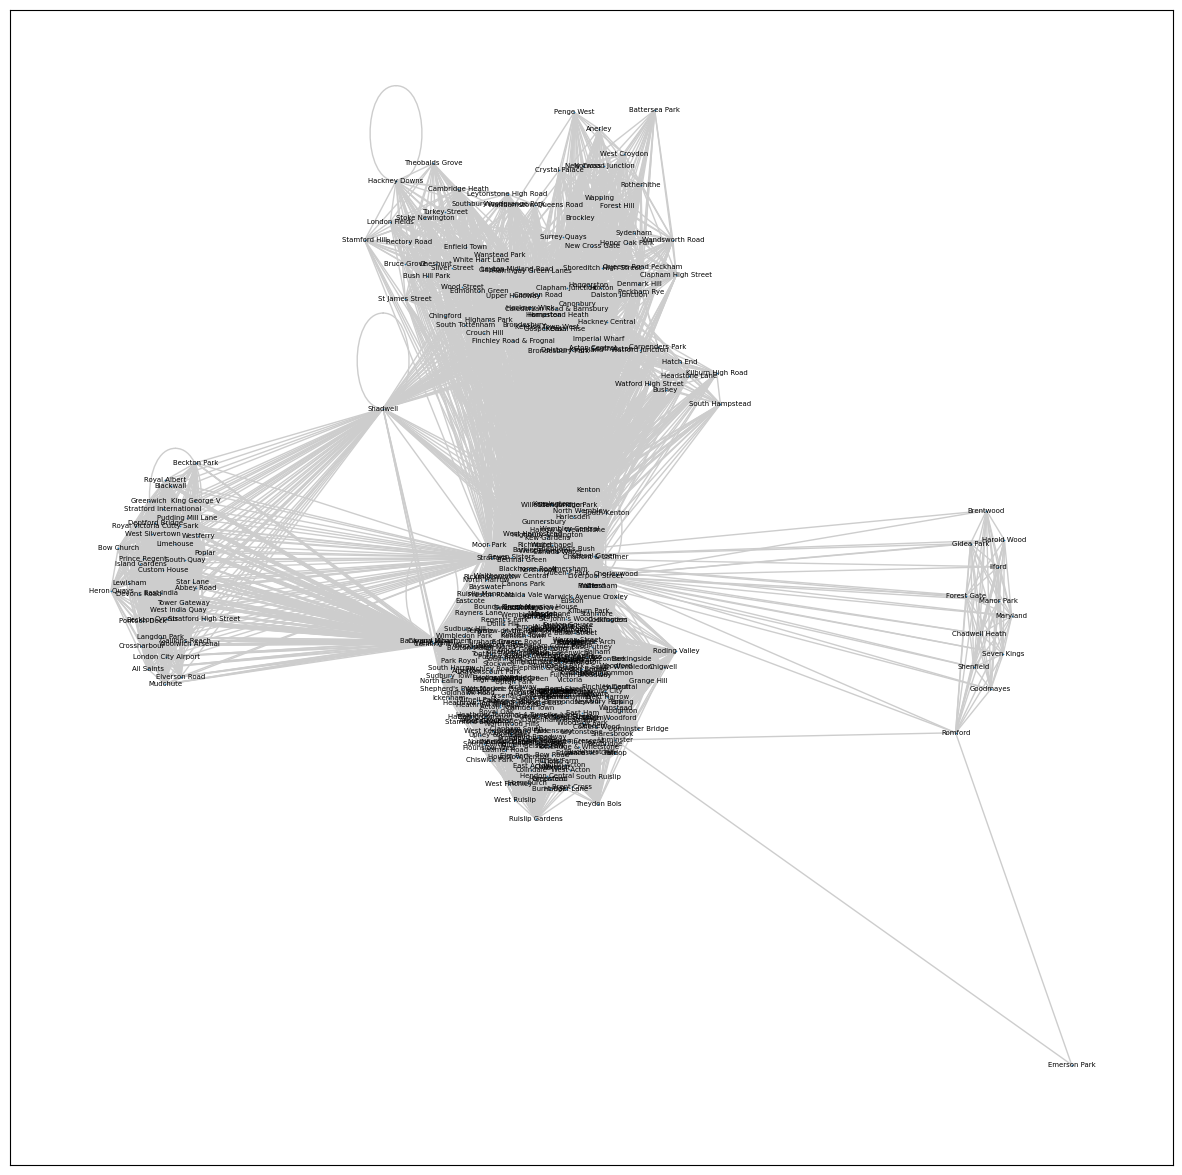

In [136]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(G, node_size=1,  font_size=5, linewidths=0.1, edge_color="#CDCDCD") # with_labels=False,

### 1.1 Centrality measures:  6 (2 per measure)

Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in this particular network. Give the definition of each of the measures (including their equation), put the measures into the context of the underground, and why they will allow you to find the stations that are most crucial for the functioning of the underground. Compute the measures for your nodes in the network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.   

#### Degree centrality

Degree Centrality (DC) is a commonly used centrality metric to measure the importance or centrality of nodes in a network. In metro networks, degree centrality can be used to assess the interactivity of stations, i.e., the number of direct connections to other stations. Degree centrality measures the number of direct connections of a node in the network, i.e., the degree of the node. A higher degree of a node indicates more direct connections to other nodes and thus plays a more important role in the network.    
For a node $i$ in an undirected network, Degree Centrality (DC) can be calculated by the following equation:
$$C_{d}(i) = \frac{k_i}{N-1} $$
where $C_d(i)$ denotes the degree centrality of node i, $k_i$ denotes the number of degrees of node i (i.e., the number of edges directly connected to node i), and $N$ denotes the total number of nodes in the network.

The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.   

In [137]:
# Topological Degree centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_centrality),'degree_centrality')
# type(degree_centrality)

dc_tube = pd.DataFrame(index=G.nodes())
dc_tube['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
dc_tube['degree_centrality'] = pd.Series(nx.get_node_attributes(G, 'degree_centrality'))
dc_tube = dc_tube.sort_values(["degree_centrality"], ascending=False).reset_index(drop=True)
# dc_tube.head(10)


#### Topological closeness centrality

Closeness Centrality is a metric used to measure the closeness between nodes and other nodes in a network. Closeness centrality measures the average shortest path length from a node to other nodes, i.e., the average distance between a node and other nodes. A higher proximity centrality of a node indicates that the distance between the node and other nodes is shorter and the connection is tighter. In a metro network, Closeness Centrality indicates the average shortest path of a station to reach other stations. The higher the value, the shorter the distance the station travels to reach the rest of the stations in the network and the more important the station is.
$$C_{c}(i) = \frac{N-1}{ {\textstyle \sum_{j=1}^{N}} d(i,j)} $$
where $C_c(i)$ denotes the proximity centrality of node i, $d(i,j)$ denotes the shortest path length from node i to node j, and $N$ denotes the total number of nodes in the network.

In [138]:
# Topological closeness centrality
closeness_centrality = nx.closeness_centrality(G) 
nx.set_node_attributes(G,dict(closeness_centrality),'closeness_centrality')
# type(closeness_centrality)

cc_tube = pd.DataFrame(index=G.nodes())
cc_tube['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
cc_tube['closeness_centrality'] = pd.Series(nx.get_node_attributes(G, 'closeness_centrality'))
cc_tube = cc_tube.sort_values(["closeness_centrality"], ascending=False).reset_index(drop=True)
# cc_tube.head(10)

#### Topological betweenness centrality

Mediation Centrality of a node (Betweenness Centrality) is used to measure the extent to which a node acts as an intermediary in the network, i.e., how often the node is on the shortest path between connecting other nodes. Nodes with high intermediary centrality usually have strong information transfer and control capabilities in the network. Mediation centrality measures the degree to which a node acts as an intermediary node in the network, i.e., the importance of the node in connecting other nodes to each other in the network. A higher intermediary centrality of a node indicates that the more frequently the node acts as an intermediary in the network and plays an important role in the connectivity and information transfer of the network.
$$C_B(v) = \sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$$

where $V$ is the set of nodes.$\sigma(s, t)$ is the number of shortest $(s, t)$-paths, and $\sigma(s, t|v)$ is the number of those paths passing through some node $v$ other than $s,t$.if $s=t, \sigma(s, t)=1$ and if $v \in {s, t}, \sigma(s, t|v) = 0$



where $C_B(v)$ denotes the intermediary centrality of node i, $\sigma_{st}(i)$ denotes the number of shortest paths from node s to node t passing through node i when node i is the intermediary node, and $\sigma_{st}$ denotes the total number of shortest paths from node s to node t.

In [139]:
# Topological betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G,normalized=True)
nx.set_node_attributes(G,dict(betweenness_centrality),'betweenness_centrality')
# type(betweenness_centrality)

bc_tube = pd.DataFrame(index=G.nodes())
bc_tube['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
bc_tube['betweenness_centrality'] = pd.Series(nx.get_node_attributes(G, 'betweenness_centrality'))
bc_tube = bc_tube.sort_values(["betweenness_centrality"], ascending=False).reset_index(drop=True)
# bc_tube.head(10)

#### Total

In [140]:
merged_df = pd.concat([dc_tube, cc_tube, bc_tube], axis=1)
merged_df.head(10)

,station_name,degree_centrality,station_name,closeness_centrality,station_name,betweenness_centrality
0,Stratford,0.922111,Stratford,0.927739,Stratford,0.098553
1,Highbury & Islington,0.806533,Highbury & Islington,0.836134,Liverpool Street,0.034307
2,Whitechapel,0.781407,Whitechapel,0.820619,Canary Wharf,0.027956
3,West Brompton,0.776382,West Brompton,0.817248,Bank and Monument,0.027956
4,Canada Water,0.771357,Canada Water,0.813906,Canning Town,0.027757
5,Canary Wharf,0.771357,Richmond,0.810591,West Ham,0.024551
6,Liverpool Street,0.768844,Canary Wharf,0.810591,Highbury & Islington,0.023023
7,Bank and Monument,0.766332,Bank and Monument,0.810591,Whitechapel,0.019682
8,Richmond,0.766332,Liverpool Street,0.808943,Canada Water,0.017898
9,Canning Town,0.763819,Canning Town,0.808943,Shadwell,0.017070


### 1.2 Impact measures:  8 (4 per measure)

Find 2 different measures to evaluate the impact of the node removal on the network. These need to be global measures referring to the whole network and not to specific nodes or links. Explain whether these two measures are specific to the London underground, or whether they could also be used to evaluate the resilience of any other network.  

Evaluation methods: Network-level Clustering coefficient, degree_assortativity_coefficient (degree assortativity coefficient)  

The average clustering coefficient reflects the average of the aggregation coefficients of all nodes in the network. The clustering coefficient is a measure of how closely a node is connected to its neighbors, and it measures the connectivity between a node's neighbors. For a subway network, the neighbors of a station are the other stations adjacent to it, so the aggregation coefficient reflects the connectivity between stations in the subway network. The higher the average aggregation coefficient, the tighter the connectivity between stations in the subway network.   

The degree assortativity coefficient directly reflects the correlation between the degrees of nodes in the network, and indirectly reflects the structural characteristics of the network. For a subway network, if there is positive degree assortativity in the subway network, then neighboring stations are usually connected to a similar number of other stations, forming a tightly connected community structure. On the contrary, if there is negative homogeneity in the subway network, then the neighboring stations are usually connected to a larger number of other stations, forming a more fragmented structure.   
   
The resilience of the network can be judged by the changes in the two indicators by removing and recalculating the nodes. If it remains unchanged or increases, it means that the network is more resilient, which means that the network is able to retain its original characteristics as much as possible. If the metric decreases, then it means that the network is less resilient in the corresponding metric, or the node has a greater impact on the network.   
    
These two measures can reflect the morphological and aggregation characteristics of the arbitrary network to some extent and are not specific to the London Underground network. For whether using these two metrics to assess the resilience of an arbitrary network will be significant, we need to consider factors such as the network's own characteristics. For example, if we are more concerned about the change of resilience of a network in the degree of aggregation, then for the arbitrary network we would be more inclined to focus on the change of the average aggregation coefficient of that network when the nodes change.

In [141]:
# Average_clustering
average_clustering = nx.algorithms.cluster.average_clustering(G)
average_clustering

0.8461409018249689

In [142]:
# degree_assortativity_coefficient
degree_assortativity_coefficient = nx.algorithms.assortativity.degree_assortativity_coefficient(G)
degree_assortativity_coefficient

0.2878494776110778

### 1.3 Node removal: 20

For each of the centrality measures selected in 1.- remove at least 10 nodes following two different strategies. A) Non-sequential removal: using your table in 1.- remove 1 node at a time following the rank in the table, i.e. from the most important one to the 10th most important one. After each removal, evaluate the impact of the removal using your two measures in 2.-, and proceed until you have removed at least 10 nodes. B) Sequential: remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality measure reflects better the importance of a station for the functioning of the underground, which strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal. 

In [143]:
def get_nonseq_removal_table(G, mode):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value", "average_clustering", "degree_assortativity_coefficient"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality = nx.degree_centrality(G2)
    elif mode == "closeness_centrality":
        centrality = nx.closeness_centrality(G2)
    elif mode == "betweenness_centrality":
        centrality = nx.betweenness_centrality(G2)
    else:
        return "Invalid mode"
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

    for i in range(10):
            node_to_delete = sorted_nodes[i][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value": [sorted_nodes[i][1]],
                                              "average_clustering": [average_clustering],
                                              "degree_assortativity_coefficient": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df

In [144]:
def get_nonseq_removal_table_weight(G, mode, weight1="flows", weight2="flows"):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value_weight", "average_clustering_weight", "degree_assortativity_coefficient_weight"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality = nx.degree_centrality(G2)
    elif mode == "closeness_centrality":
        centrality = nx.closeness_centrality(G2, weight=weight1)
    elif mode == "betweenness_centrality":
        centrality = nx.betweenness_centrality(G2, weight=weight1)
    else:
        return "Invalid mode"
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

    for i in range(10):
            node_to_delete = sorted_nodes[i][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2, weight=weight2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2, weight=weight2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value_weight": [sorted_nodes[i][1]],
                                              "average_clustering_weight": [average_clustering],
                                              "degree_assortativity_coefficient_weight": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df

In [145]:
def get_seq_removal_table(G, mode):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value", "average_clustering", "degree_assortativity_coefficient"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality_func = nx.degree_centrality
    elif mode == "closeness_centrality":
        centrality_func = nx.closeness_centrality
    elif mode == "betweenness_centrality":
        centrality_func = nx.betweenness_centrality
    else:
        return "Invalid mode"
    for i in range(10):
            sorted_nodes = sorted(centrality_func(G2).items(), key=lambda x: x[1], reverse=True)
            node_to_delete = sorted_nodes[0][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value": [sorted_nodes[0][1]],
                                              "average_clustering": [average_clustering],
                                              "degree_assortativity_coefficient": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df


In [146]:
def get_seq_removal_table_weight(G, mode, weight1="flows", weight2="flows"):
    df = pd.DataFrame(columns=["deleted_station_id", "centrality_value_weight", "average_clustering_weight", "degree_assortativity_coefficient_weight"])
    G2 = nx.Graph(G)
    
    if mode == "degree_centrality":
        centrality_func = nx.degree_centrality
    elif mode == "closeness_centrality":
        centrality_func = nx.closeness_centrality
    elif mode == "betweenness_centrality":
        centrality_func = nx.betweenness_centrality
    else:
        return "Invalid mode"
    for i in range(10):
            sorted_nodes = sorted(centrality_func(G2, weight=weight1).items(), key=lambda x: x[1], reverse=True)
            node_to_delete = sorted_nodes[0][0]
            G2.remove_node(node_to_delete)
            average_clustering = nx.average_clustering(G2, weight=weight2)
            degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G2, weight=weight2)
            df = pd.concat([df, pd.DataFrame({"deleted_station_id": [node_to_delete],
                                              "centrality_value_weight": [sorted_nodes[0][1]],
                                              "average_clustering_weight": [average_clustering],
                                              "degree_assortativity_coefficient_weight": [degree_assortativity_coefficient]})],
                                              ignore_index=True)
    return df


#### A) Non-sequential removal:

In [147]:
dc_nonseq_removal_table = get_nonseq_removal_table(G, "degree_centrality")
dc_nonseq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.922111,0.845247,0.318954
1,Highbury & Islington,0.806533,0.844518,0.331850
2,Whitechapel,0.781407,0.843820,0.341482
3,West Brompton,0.776382,0.843457,0.351806
4,Canary Wharf,0.771357,0.842905,0.360748
5,Canada Water,0.771357,0.842080,0.369816
6,Liverpool Street,0.768844,0.841604,0.379064
7,Bank and Monument,0.766332,0.841012,0.388914
8,Richmond,0.766332,0.840537,0.400930
9,Canning Town,0.763819,0.839916,0.411489


In [148]:
cc_nonseq_removal_table = get_nonseq_removal_table(G, "closeness_centrality")
cc_nonseq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.927739,0.845247,0.318954
1,Highbury & Islington,0.836134,0.844518,0.331850
2,Whitechapel,0.820619,0.843820,0.341482
3,West Brompton,0.817248,0.843457,0.351806
4,Canada Water,0.813906,0.842637,0.360552
5,Bank and Monument,0.810591,0.842080,0.369575
6,Canary Wharf,0.810591,0.841493,0.379297
7,Richmond,0.810591,0.841015,0.390853
8,Canning Town,0.808943,0.840399,0.400999
9,Liverpool Street,0.808943,0.839916,0.411489


In [149]:
bc_nonseq_removal_table = get_nonseq_removal_table(G, "betweenness_centrality")
bc_nonseq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.098553,0.845247,0.318954
1,Liverpool Street,0.034307,0.844742,0.326372
2,Bank and Monument,0.027956,0.844201,0.334331
3,Canary Wharf,0.027956,0.843630,0.342888
4,Canning Town,0.027757,0.843033,0.351457
5,West Ham,0.024551,0.842841,0.358271
6,Highbury & Islington,0.023023,0.842107,0.373238
7,Whitechapel,0.019682,0.841400,0.384574
8,Canada Water,0.017898,0.840572,0.394525
9,Shadwell,0.017070,0.840972,0.391025


#### B) Sequential removal:

In [150]:
dc_seq_removal_table = get_seq_removal_table(G, 'degree_centrality')
dc_seq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.922111,0.845247,0.318954
1,Highbury & Islington,0.806045,0.844518,0.331850
2,Whitechapel,0.780303,0.843820,0.341482
3,West Brompton,0.774684,0.843457,0.351806
4,Canary Wharf,0.769036,0.842905,0.360748
5,Canada Water,0.768448,0.842080,0.369816
6,Liverpool Street,0.765306,0.841604,0.379064
7,Bank and Monument,0.762148,0.841012,0.388914
8,Richmond,0.761538,0.840537,0.400930
9,Canning Town,0.758355,0.839916,0.411489


In [151]:
cc_seq_removal_table = get_seq_removal_table(G, "closeness_centrality")
cc_seq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.927739,0.845247,0.318954
1,Highbury & Islington,0.835789,0.844518,0.331850
2,Whitechapel,0.819876,0.843820,0.341482
3,West Brompton,0.816116,0.843457,0.351806
4,Canada Water,0.812371,0.842637,0.360552
5,Bank and Monument,0.808642,0.842080,0.369575
6,Canary Wharf,0.808247,0.841493,0.379297
7,Richmond,0.807851,0.841015,0.390853
8,Canning Town,0.805785,0.840399,0.400999
9,Liverpool Street,0.802062,0.839916,0.411489


In [152]:
bc_seq_removal_table = get_seq_removal_table(G, "betweenness_centrality")
bc_seq_removal_table

,deleted_station_id,centrality_value,average_clustering,degree_assortativity_coefficient
0,Stratford,0.098553,0.845247,0.318954
1,Liverpool Street,0.070415,0.844742,0.326372
2,Upminster,0.063741,0.842781,0.328387
3,Bank and Monument,0.038087,0.842236,0.336381
4,Canary Wharf,0.051103,0.841662,0.344978
5,Canning Town,0.077786,0.841062,0.353587
6,West Ham,0.135600,0.840870,0.360432
7,Shadwell,0.173609,0.841341,0.357411
8,Highbury & Islington,0.025566,0.840562,0.372494
9,Whitechapel,0.024413,0.839827,0.383745


#### Disscustion

In [153]:
# Divide the DataFrame into three groups according to centrality type
dc_nonseq = dc_nonseq_removal_table.copy()
dc_seq = dc_seq_removal_table.copy()

cc_nonseq = cc_nonseq_removal_table.copy()
cc_seq = cc_seq_removal_table.copy()

bc_nonseq = bc_nonseq_removal_table.copy()
bc_seq = bc_seq_removal_table.copy()

# Reset the index of each DataFrame and remove the deleted_station_id field
dc_nonseq = dc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
dc_seq = dc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)

cc_nonseq = cc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
cc_seq = cc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)

bc_nonseq = bc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
bc_seq = bc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)


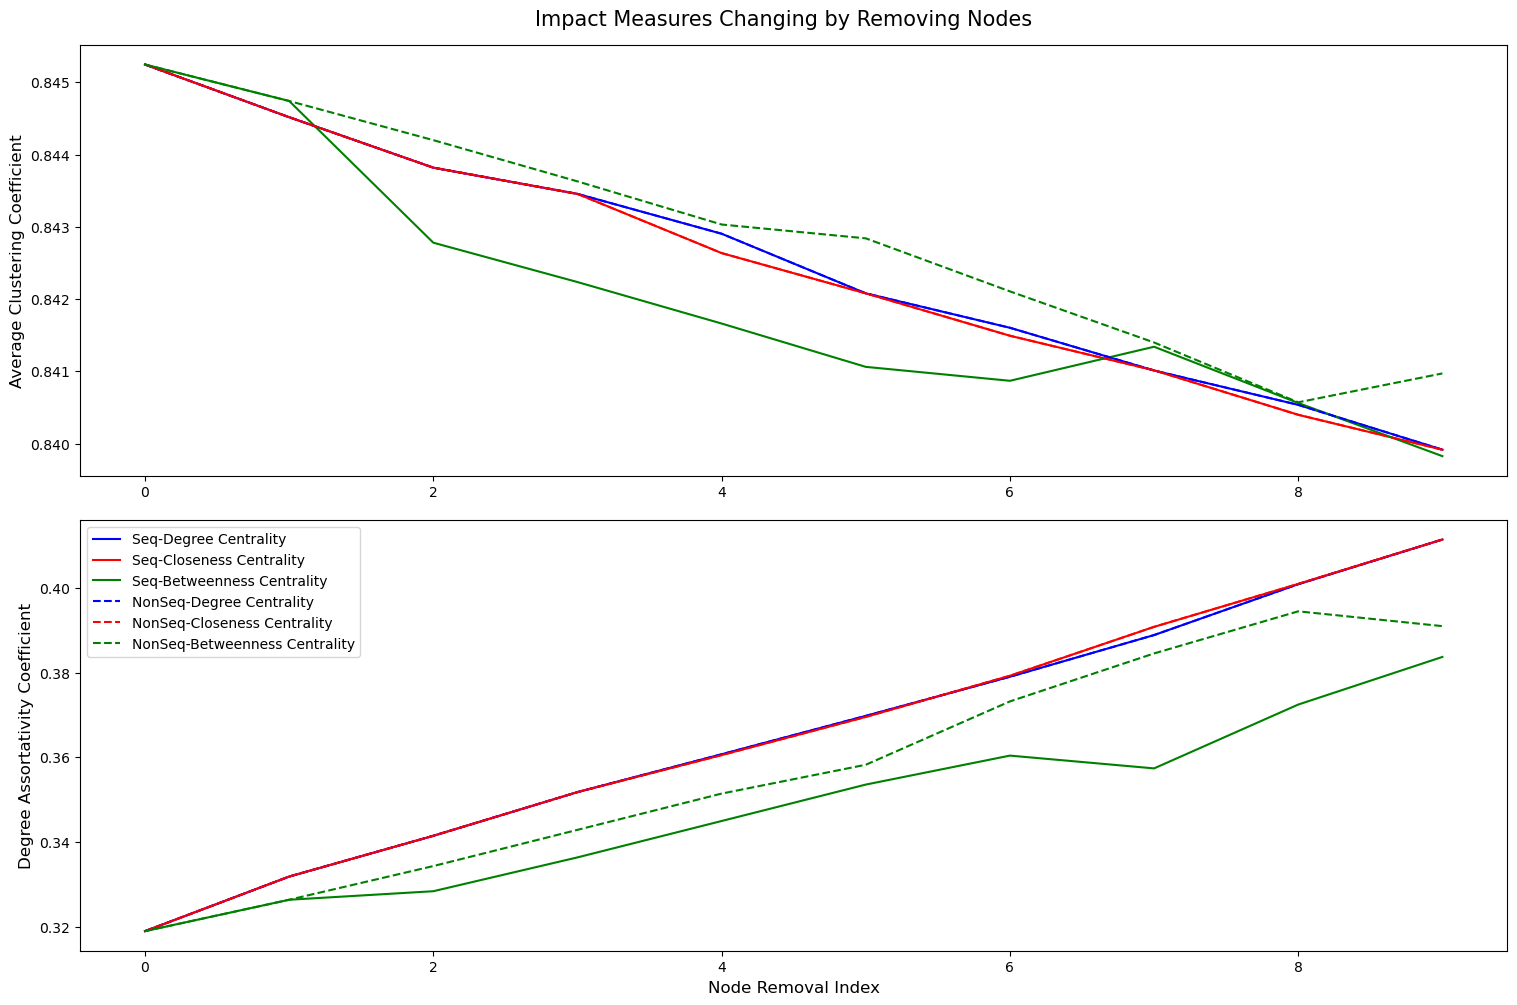

In [154]:
# Set graph size, title, subplot layout and axis labels
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plt.suptitle("Impact Measures Changing by Removing Nodes", fontsize=15)
fig.tight_layout()
axs[0].set_ylabel('Average Clustering Coefficient', fontsize=12)
axs[1].set_ylabel('Degree Assortativity Coefficient', fontsize=12)
axs[1].set_xlabel('Node Removal Index', fontsize=12)

# Plot subfigure 1, using the solid line for seq data and the dashed line for nonseq data
axs[0].plot(dc_seq['average_clustering'], label='Degree Centrality (Seq)', color='blue')
axs[0].plot(cc_seq['average_clustering'], label='Closeness Centrality (Seq)', color='red')
axs[0].plot(bc_seq['average_clustering'], label='Betweenness Centrality (Seq)', color='green')
axs[0].plot(dc_nonseq['average_clustering'], '--', label='Degree Centrality (Nonseq)', color='blue')
axs[0].plot(cc_nonseq['average_clustering'], '--', label='Closeness Centrality (Nonseq)', color='red')
axs[0].plot(bc_nonseq['average_clustering'], '--', label='Betweenness Centrality (Nonseq)', color='green')

# Plot subfigure 2, using the solid line for seq data and the dashed line for nonseq data
axs[1].plot(dc_seq['degree_assortativity_coefficient'], label='Degree Centrality (Seq)', color='blue')
axs[1].plot(cc_seq['degree_assortativity_coefficient'], label='Closeness Centrality (Seq)', color='red')
axs[1].plot(bc_seq['degree_assortativity_coefficient'], label='Betweenness Centrality (Seq)', color='green')
axs[1].plot(dc_nonseq['degree_assortativity_coefficient'], '--', label='Degree Centrality (Nonseq)', color='blue')
axs[1].plot(cc_nonseq['degree_assortativity_coefficient'], '--', label='Closeness Centrality (Nonseq)', color='red')
axs[1].plot(bc_nonseq['degree_assortativity_coefficient'], '--', label='Betweenness Centrality (Nonseq)', color='green')

axs[1].legend(["Seq-Degree Centrality", "Seq-Closeness Centrality", "Seq-Betweenness Centrality", 
            "NonSeq-Degree Centrality", "NonSeq-Closeness Centrality", "NonSeq-Betweenness Centrality"])


## II. Flows: weighted network:  14 marks

In this section, you will include passengers into the underground, and assess whether different measures need to be used when flows are considered. The network to use in this section is the weighted network given to you in the coursework, where the flows of passengers were assigned to the links between stations.   
II.1. Consider the centrality measure derived in I.- indicating the most relevant stations for assessing the vulnerability of the underground. What would you need to do to adjust this measure for a weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted measure. Do you find the same ones as in I.1?   
II.2. Now consider the measure for assessing the impact of node removal. Would you adjust the measure for a weighted network? If yes, how? Propose a different measure that would be better at assessing the impact of closing a station taking into consideration the passengers.   
II.3. Remove only the 3 highest ranked nodes according to the best performing centrality measure found in I.1. Evaluate the impact according to the 2 measures in II.2. Repeat the experiment for the highest 3 ranked nodes using the adjusted measure. Critically discuss which station closure will have the largest impact on passengers, referring to your measures and results.   

### II.1. Old vs new measure: 3

In [155]:
# Closeness centrality
closeness_centrality = nx.closeness_centrality(G, distance='flows_normalized_weight') 
nx.set_node_attributes(G,dict(closeness_centrality),'closeness_centrality_weight')
# type(closeness_centrality)

cc_tube_weight = pd.DataFrame(index=G.nodes())
cc_tube_weight['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
cc_tube_weight['closeness_centrality_weight'] = pd.Series(nx.get_node_attributes(G, 'closeness_centrality_weight'))
cc_tube_weight = cc_tube_weight.sort_values(["closeness_centrality_weight"], ascending=False).reset_index(drop=True)
# cc_tube_weight.head(10)

In [156]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G,weight='flows_normalized_weight')
nx.set_node_attributes(G,dict(betweenness_centrality),'betweenness_centrality_weight')
# type(betweenness_centrality)

bc_tube_weight = pd.DataFrame(index=G.nodes())
bc_tube_weight['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
bc_tube_weight['betweenness_centrality_weight'] = pd.Series(nx.get_node_attributes(G, 'betweenness_centrality_weight'))
bc_tube_weight = bc_tube_weight.sort_values(["betweenness_centrality_weight"], ascending=False).reset_index(drop=True)
# bc_tube_weight.head(10)

In [157]:
merged_df_weight = pd.concat([cc_tube, cc_tube_weight, bc_tube, bc_tube_weight], axis=1)
merged_df_weight.head(10)

,station_name,closeness_centrality,station_name,closeness_centrality_weight,station_name,betweenness_centrality,station_name,betweenness_centrality_weight
0,Stratford,0.927739,Stratford,0.944876,Stratford,0.098553,Stratford,0.132384
1,Highbury & Islington,0.836134,Liverpool Street,0.869680,Liverpool Street,0.034307,Bank and Monument,0.125460
2,Whitechapel,0.820619,Highbury & Islington,0.851008,Canary Wharf,0.027956,Canada Water,0.063178
3,West Brompton,0.817248,Canary Wharf,0.847229,Bank and Monument,0.027956,Liverpool Street,0.061327
4,Canada Water,0.813906,Bank and Monument,0.838551,Canning Town,0.027757,Waterloo,0.046047
5,Richmond,0.810591,Waterloo,0.838551,West Ham,0.024551,Highbury & Islington,0.028894
6,Canary Wharf,0.810591,Whitechapel,0.827934,Highbury & Islington,0.023023,Seven Sisters,0.024588
7,Bank and Monument,0.810591,Canada Water,0.826647,Whitechapel,0.019682,Barking,0.021002
8,Liverpool Street,0.808943,Canning Town,0.823384,Canada Water,0.017898,Canning Town,0.019432
9,Canning Town,0.808943,West Brompton,0.822428,Shadwell,0.017070,Canary Wharf,0.017379


### II.2. Impact measure with flows: 3

In [158]:
# Average_clustering_weight
average_clustering_weight = nx.algorithms.cluster.average_clustering(G, weight='flows_normalized')
average_clustering_weight

0.0005543817457936487

In [159]:
# degree_assortativity_coefficient
degree_assortativity_coefficient_weight = nx.algorithms.assortativity.degree_assortativity_coefficient(G, weight='flows_normalized')
degree_assortativity_coefficient_weight

-0.03774129197190707

Average shortest path length (Average shortest path length): the average of the shortest path length between all node pairs. Generally speaking, the smaller the average shortest path length, the more connected the nodes are and the faster the information is disseminated.
For the London Underground network, the smaller the value, the fewer the number of stops a passenger needs to go through to get from the origin to the destination.

In [160]:
# average_shortest_path_length
average_shortest_path_length_weight = nx.average_shortest_path_length(G, weight='flows_normalized_weight')
average_shortest_path_length_weight

1.589256953706221

### II.3. Experiment with flows: 8

In [161]:
bc_nonseq_removal_table_weight = get_nonseq_removal_table_weight(G, 'betweenness_centrality', weight1='flows_normalized_weight', weight2='flows_normalized')
bc_nonseq_removal_table_weight

,deleted_station_id,centrality_value_weight,average_clustering_weight,degree_assortativity_coefficient_weight
0,Stratford,0.132384,0.000495,-0.031957
1,Bank and Monument,0.125460,0.000895,-0.035445
2,Canada Water,0.063178,0.000871,-0.032906
3,Liverpool Street,0.061327,0.000795,-0.030939
4,Waterloo,0.046047,0.001011,-0.035138
5,Highbury & Islington,0.028894,0.000996,-0.030802
6,Seven Sisters,0.024588,0.000975,-0.029663
7,Barking,0.021002,0.000976,-0.029385
8,Canning Town,0.019432,0.000948,-0.027147
9,Canary Wharf,0.017379,0.001068,-0.024770


In [162]:
bc_seq_removal_table_weight = get_seq_removal_table_weight(G, 'betweenness_centrality', weight1='flows_normalized_weight', weight2='flows_normalized')
bc_seq_removal_table_weight

,deleted_station_id,centrality_value_weight,average_clustering_weight,degree_assortativity_coefficient_weight
0,Stratford,0.132384,0.000495,-0.031957
1,Bank and Monument,0.173572,0.000895,-0.035445
2,Liverpool Street,0.107691,0.000820,-0.033691
3,Canary Wharf,0.103262,0.001216,-0.034919
4,Canning Town,0.126193,0.001185,-0.032513
5,West Ham,0.143535,0.001185,-0.031963
6,Shadwell,0.179798,0.001160,-0.031411
7,Canada Water,0.067308,0.001123,-0.028118
8,Highbury & Islington,0.069389,0.001104,-0.023300
9,Whitechapel,0.086867,0.001088,-0.020917


In [165]:
bc_nonseq = bc_nonseq_removal_table_weight.copy()
bc_seq = bc_seq_removal_table_weight.copy()

# bc_nonseq = bc_nonseq.drop(columns=['deleted_station_id']).reset_index(drop=True)
# bc_seq = bc_seq.drop(columns=['deleted_station_id']).reset_index(drop=True)
bc_nonseq = bc_nonseq.reset_index(drop=True)
bc_seq = bc_seq.reset_index(drop=True)

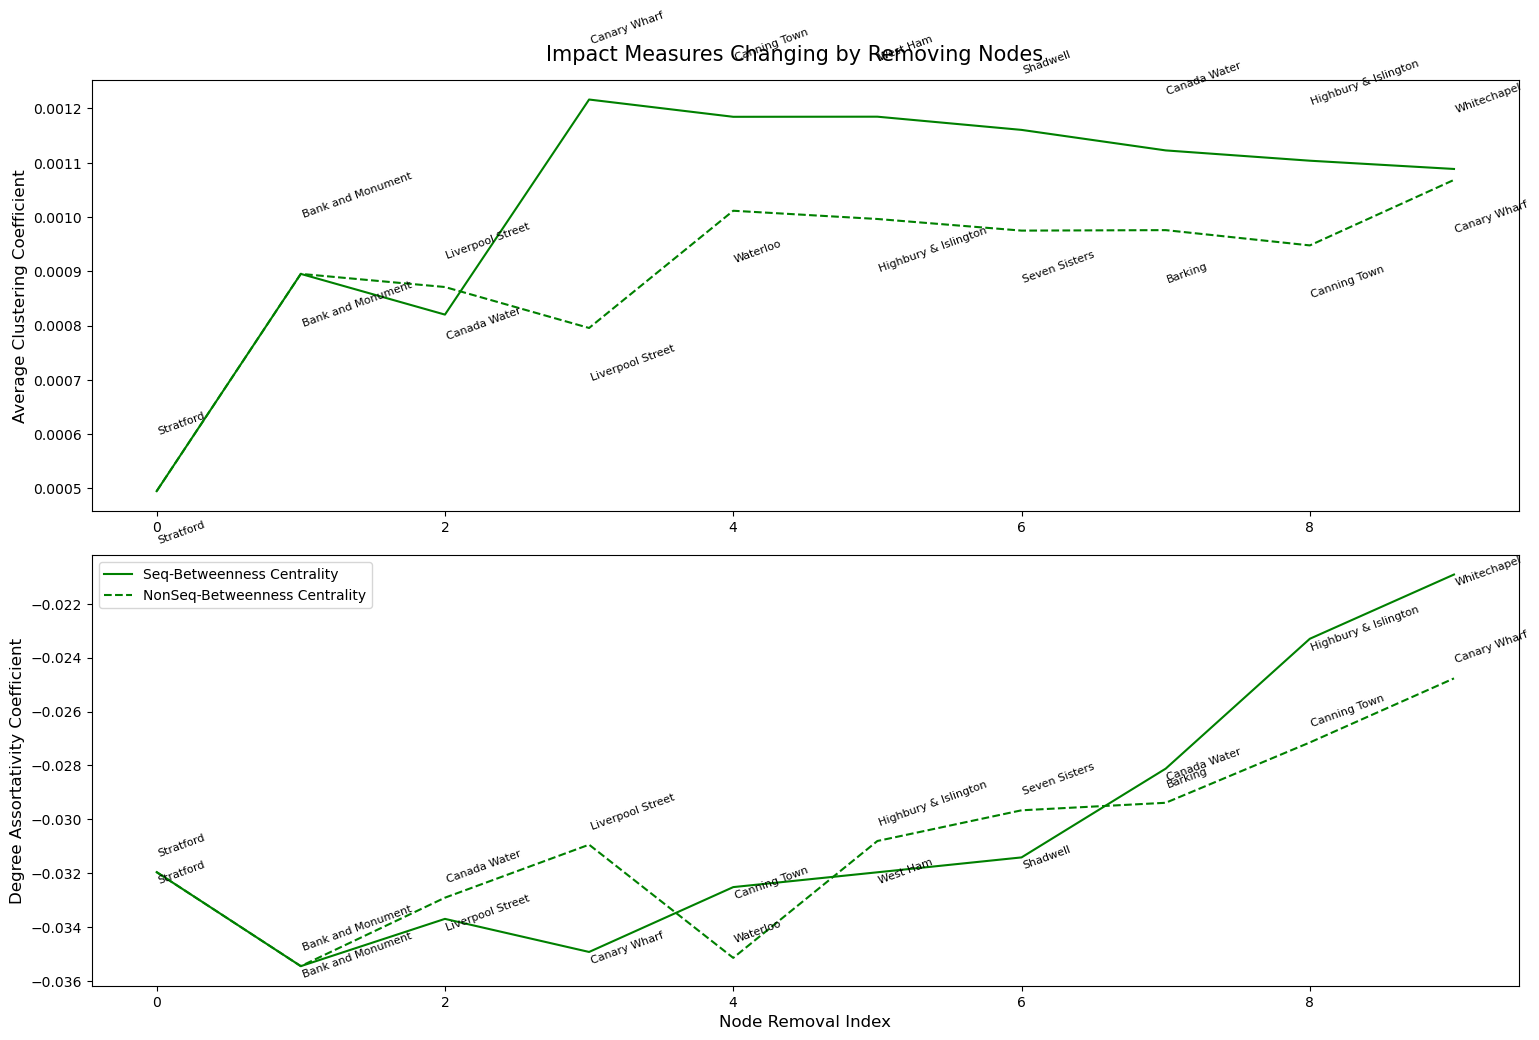

In [171]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plt.suptitle("Impact Measures Changing by Removing Nodes", fontsize=15)
fig.tight_layout()
axs[0].set_ylabel('Average Clustering Coefficient', fontsize=12)
axs[1].set_ylabel('Degree Assortativity Coefficient', fontsize=12)
axs[1].set_xlabel('Node Removal Index', fontsize=12)

axs[0].plot(bc_seq['average_clustering_weight'], label='Betweenness Centrality (Seq)', color='green')
axs[0].plot(bc_nonseq['average_clustering_weight'], '--', label='Betweenness Centrality (Nonseq)', color='green')

for i, row in bc_seq.iterrows():
    axs[0].annotate(row['deleted_station_id'], xy=(i, row['average_clustering_weight']), xytext=(i, row['average_clustering_weight']+0.0001), fontsize=8, rotation=20, ha='left', va='bottom')
for i, row in bc_nonseq.iterrows():
    axs[0].annotate(row['deleted_station_id'], xy=(i, row['average_clustering_weight']), xytext=(i, row['average_clustering_weight']-0.0001), fontsize=8, rotation=20, ha='left', va='bottom')


axs[1].plot(bc_seq['degree_assortativity_coefficient_weight'], label='Betweenness Centrality (Seq)', color='green')
axs[1].plot(bc_nonseq['degree_assortativity_coefficient_weight'], '--', label='Betweenness Centrality (Nonseq)', color='green')

for i, row in bc_seq.iterrows():
    axs[1].annotate(row['deleted_station_id'], xy=(i, row['degree_assortativity_coefficient_weight']), xytext=(i, row['degree_assortativity_coefficient_weight']-0.0005), fontsize=8, rotation=20, ha='left', va='bottom')
for i, row in bc_nonseq.iterrows():
    axs[1].annotate(row['deleted_station_id'], xy=(i, row['degree_assortativity_coefficient_weight']), xytext=(i, row['degree_assortativity_coefficient_weight']+0.0005), fontsize=8, rotation=20, ha='left', va='bottom')

axs[1].legend(["Seq-Betweenness Centrality", "NonSeq-Betweenness Centrality"])


# Part 2: Spatial Interaction models: 50 marks

For this section, you will be given a “symbolic” population and the number of jobs for the stations in the underground. You will also be given the number of people that commute from one station to another, through an OD matrix.

## III. Models and calibration: 18

### III.1   8

Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.    

####  Gravity model

#### ABM

### III.2 10

Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as $\beta$). It is essential that you justify the model selected.       

The target of spatial interaction model is to models and predicts the number of occurrences of events in a certain time period. Thus, Poisson regression is chosen to build the prediction model. Because Poisson regression models assume that the response variables are Poisson distributed and model and predict count data better. As a result, we can build a Production-constrained Model by using the formula: 
$$
T_{ij} = A_i O_i D_j d_{ij}^{-\beta}
$$   
Where   
$$
O_i = \sum_j T_{ij}
$$   
and   
$$
A_i = \frac{1}{\sum_j D_j d_{ij}^{-\beta}}
$$   
Thus, we can get the formula as:    
$$   
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})   
$$    
Where $\alpha_i$ is the equivalent of the vector of balancing factors $A_i$,  $D_j$ is the jobs count in the destination area and $d_{ij}$ is the distance between OD. 


In [203]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

def print_diff_mat(diff_mat_1, diff_mat_2):
    diff_mat = diff_mat_1 - diff_mat_2
    diff_mat.drop(index=["All"], columns=["All"], inplace=True)

    vmin = diff_mat.min().min()
    vmax = diff_mat.max().max()

    fig, ax = plt.subplots(figsize=(18, 18))
    im = ax.imshow(diff_mat, cmap='RdBu', vmin=vmin, vmax=vmax)

    cbar = ax.figure.colorbar(im, ax=ax)

    ax.tick_params(top=False, bottom=False, labeltop=False, labelbottom=False)

    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.show()

def get_max_min(diff_mat_1, diff_mat_2):
    diff_mat = diff_mat_1 - diff_mat_2
    diff_mat.drop(index=["All"], columns=["All"], inplace=True)
    vmin = diff_mat.min().min()
    vmax = diff_mat.max().max()
    return (vmin, vmax)

In [173]:
# read csv and clean the 0 value, save as df
csv = pd.read_csv('./data/london_flows.csv')
df = csv.replace(0, 0.001)
df['log_job'] = np.log(df['jobs'])
df['log_dis'] = np.log(df['distance'])
df.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012


In [174]:
# create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_job + log_dis-1'   #
# run a constrained model
conSim = smf.glm(formula = formula, data=df, family=sm.families.Poisson()).fit()
# get the summary
print(conSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2393e+06
Date:                Mon, 01 May 2023   Deviance:                   2.3061e+06
Time:                        04:54:43   Pearson chi2:                 4.44e+06
No. Iterations:                    16   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Using Python, the Poisson regression model was built and the distance cost coefficient is calculated as: $\beta = -0.12285035011456112$ 

In [175]:
O_i = pd.DataFrame(df.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
df = df.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(df.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df = df.merge(D_j, on = "station_destination", how = "left" )

df.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504,599.004,78549.006
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012,599.004,442.011


In [176]:
coefs = pd.DataFrame(conSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["station_origin", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].apply(lambda s: re.sub(x, "", s))
    
df = df.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
df.drop(columns = ["coef"], inplace = True)

df.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504,599.004,78549.006,-3.179183
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012,599.004,442.011,-3.179183


In [177]:
conSim.params

station_origin[Abbey Road]         -3.179183
station_origin[Acton Central]      -2.406603
station_origin[Acton Town]         -2.982490
station_origin[Aldgate]            -3.368974
station_origin[Aldgate East]       -3.286831
                                      ...   
station_origin[Woodgrange Park]    -2.090147
station_origin[Woodside Park]      -3.093014
station_origin[Woolwich Arsenal]   -0.507988
log_job                             0.815642
log_dis                            -0.122850
Length: 401, dtype: float64

In [178]:
# save the parameter
alpha_i = conSim.params[0:399]
gamma = conSim.params[399]
beta = -conSim.params[400]

In [179]:
beta

0.12285035011456112

#### validation

In [180]:
# calcualte the result/ Do the prediction
df["sim_pre"] = np.exp(df["alpha_i"] + gamma*df['log_job'] - beta*df["log_dis"])
df["sim_pre"] = round(df["sim_pre"], 0)
df.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i,sim_pre
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504,599.004,78549.006,-3.179183,135.0
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012,599.004,442.011,-3.179183,2.0


In [181]:
test_mat = df.pivot_table(values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
test_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.000,599.004
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN,1224.024
Acton Town,NaN,NaN,NaN,3.000,17.000,NaN,35.000,0.001,NaN,11.00,...,77.000,3.000,6.000,9.000,NaN,0.001,NaN,0.001,NaN,3745.052
Aldgate,NaN,NaN,0.001,NaN,0.001,NaN,NaN,0.001,NaN,17.00,...,0.001,NaN,4.000,8.000,NaN,0.001,NaN,0.001,NaN,2886.114
Aldgate East,NaN,NaN,2.000,0.001,NaN,NaN,0.001,0.001,NaN,20.00,...,24.000,0.001,0.001,12.000,NaN,1.000,NaN,1.000,NaN,3172.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.000,5.000,47.000,NaN,NaN,NaN,NaN,22.00,...,2.000,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,4868.025
Woodgrange Park,NaN,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.013
Woodside Park,NaN,NaN,1.000,26.000,11.000,NaN,0.001,NaN,NaN,59.00,...,0.001,NaN,0.001,NaN,NaN,NaN,NaN,NaN,NaN,3093.029


In [182]:
pre_mat = df.pivot_table(values ="sim_pre", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
pre_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,4.0,1.0,NaN,24.0,...,19.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,3750.0
Aldgate,NaN,NaN,6.0,NaN,21.0,NaN,NaN,1.0,NaN,19.0,...,13.0,NaN,6.0,4.0,NaN,2.0,NaN,2.0,NaN,2890.0
Aldgate East,NaN,NaN,6.0,23.0,NaN,NaN,2.0,1.0,NaN,21.0,...,14.0,2.0,6.0,5.0,NaN,2.0,NaN,2.0,NaN,3170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,32.0,32.0,NaN,NaN,NaN,NaN,32.0,...,24.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,7.0,20.0,21.0,NaN,3.0,NaN,NaN,22.0,...,16.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [183]:
R2 = CalcRSquared(df["flows"], df["sim_pre"])
RMSE = CalcRMSE(df["flows"], df["sim_pre"])
print('The R2 of the result is: ' + str(R2) + '\n' +
      'The RMSE of the reult is: ' + str(RMSE))

The R2 of the result is: 0.28991866504073127
The RMSE of the reult is: 111.276


## IV. Scenarios 30 marks

### IV.1  8

Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the calibrated parameter $\beta$, compute the new flows for scenario A. Make sure the number of commuters is conserved, and explain how you ensured this.   

In [184]:
df_SA = df.copy()
df_SA.loc[df_SA['station_destination'] == 'Canary Wharf'].head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i,sim_pre
3,Abbey Road,Canary Wharf,1.0,599.0,58772.0,5086.514220,10.981421,8.534348,599.004,58772.01,-3.179183,113.0
126,Acton Town,Canary Wharf,57.0,3745.0,58772.0,20398.165882,10.981421,9.923200,3745.052,58772.01,-2.982490,116.0


In [185]:
# Change the job at Canary Wharf
df_SA['jobs_SA'] = df_SA['jobs']
df_SA.loc[df_SA['station_destination'] == 'Canary Wharf', 'jobs_SA'] = df_SA['jobs'] / 2
df_SA['log_jobs_SA'] = np.log(df_SA['jobs_SA'])
df_SA.loc[df_SA['station_destination'] == 'Canary Wharf'].head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i,sim_pre,jobs_SA,log_jobs_SA
3,Abbey Road,Canary Wharf,1.0,599.0,58772.0,5086.514220,10.981421,8.534348,599.004,58772.01,-3.179183,113.0,29386.0,10.288274
126,Acton Town,Canary Wharf,57.0,3745.0,58772.0,20398.165882,10.981421,9.923200,3745.052,58772.01,-2.982490,116.0,29386.0,10.288274


In [186]:
#calculate some new D_j_1_gamma and dist_beta values
D_j_1_gamma = df_SA["jobs_SA"]**gamma
dist_beta = df_SA["distance"]**-beta
#calcualte the first stage of the Ai values
df_SA["Ai1"] = D_j_1_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(df_SA.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
df_SA = df_SA.merge(A_i, left_on="station_origin", right_index=True, how="left")
df_SA.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i,sim_pre,jobs_SA,log_jobs_SA,Ai1,A_i2
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504,599.004,78549.006,-3.179183,135.0,78549.0,11.271478,3253.248963,0.000076
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012,599.004,442.011,-3.179183,2.0,442.0,6.091310,47.306853,0.000076


In [187]:
# predict with new coefficient
df_SA['sim_pre_SA'] = df_SA['A_i2']*df_SA['O_i']*D_j_1_gamma*dist_beta
df_SA['sim_pre_SA'] = round(df_SA['sim_pre_SA'])

In [188]:
sim_SA_mat = df_SA.pivot_table(values ="sim_pre_SA", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
sim_SA_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,4.0,1.0,NaN,24.0,...,20.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,3742.0
Aldgate,NaN,NaN,6.0,NaN,22.0,NaN,NaN,1.0,NaN,20.0,...,13.0,NaN,6.0,4.0,NaN,2.0,NaN,2.0,NaN,2888.0
Aldgate East,NaN,NaN,6.0,23.0,NaN,NaN,2.0,1.0,NaN,21.0,...,14.0,2.0,6.0,5.0,NaN,2.0,NaN,3.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,11.0,32.0,33.0,NaN,NaN,NaN,NaN,33.0,...,25.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4871.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,7.0,21.0,21.0,NaN,3.0,NaN,NaN,22.0,...,16.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


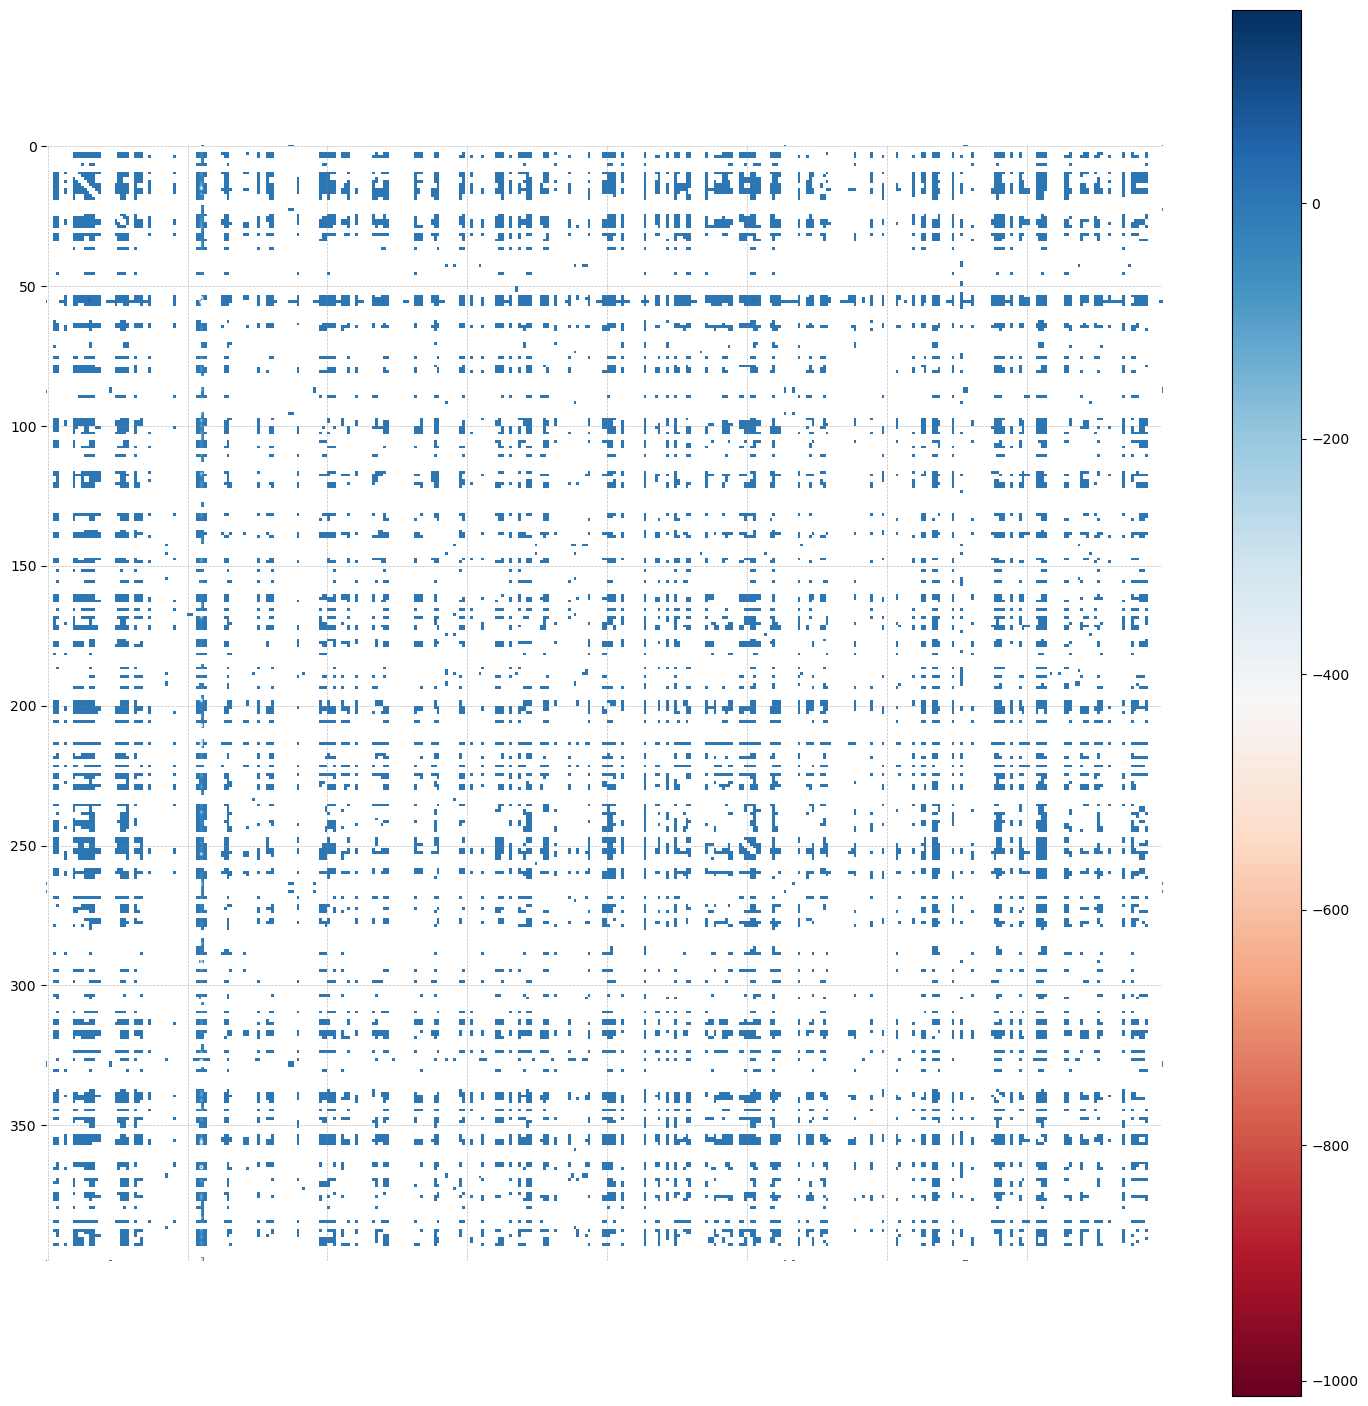

In [189]:
print_diff_mat(sim_SA_mat, pre_mat)

In [204]:
get_max_min(sim_SA_mat, pre_mat)

(-1013.0, 164.0)

### IV.2  12

Scenario B: assume that there is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B. Recompute the distribution of flows.   

Define the distance cost function as
$$
d_{ij} = \mu \cdot D_{ij}
$$
Where $\mu$ is the cost coefficient, $D_{ij}$ is the distance between origin $i$ and detination $j$.    
Thus, we can get the latest constrained gravity model as 
$$
\lambda _{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln (\mu \cdot D_{ij}))   
$$


In [190]:
mu_1 = 1.1
mu_2 = 1.3

In [191]:
df_SB = df.copy()
df_SB.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i,sim_pre
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504,599.004,78549.006,-3.179183,135.0
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012,599.004,442.011,-3.179183,2.0


In [192]:
df_SB['log_dis_SB1'] = np.log(df_SB['distance']*mu_1)
df_SB['log_dis_SB2'] = np.log(df_SB['distance']*mu_2)

In [193]:
df_SB["sim_pre_SB1"] = np.exp(df_SB["alpha_i"] + gamma*df_SB['log_job'] - beta*df_SB["log_dis_SB1"])
df_SB["sim_pre_SB2"] = np.exp(df_SB["alpha_i"] + gamma*df_SB['log_job'] - beta*df_SB["log_dis_SB2"])
df_SB.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_job,log_dis,O_i,D_j,alpha_i,sim_pre,log_dis_SB1,log_dis_SB2,sim_pre_SB1,sim_pre_SB2
0,Abbey Road,Bank and Monument,0.001,599.0,78549.0,8131.525097,11.271478,9.003504,599.004,78549.006,-3.179183,135.0,9.098814,9.265868,133.822875,131.104465
1,Abbey Road,Beckton,1.000,599.0,442.0,8510.121774,6.091310,9.049012,599.004,442.011,-3.179183,2.0,9.144322,9.311376,1.945974,1.906445


In [194]:
SB_0_mat = df_SB.pivot_table(values ="sim_pre", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
SB_0_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,4.0,1.0,NaN,24.0,...,19.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,3750.0
Aldgate,NaN,NaN,6.0,NaN,21.0,NaN,NaN,1.0,NaN,19.0,...,13.0,NaN,6.0,4.0,NaN,2.0,NaN,2.0,NaN,2890.0
Aldgate East,NaN,NaN,6.0,23.0,NaN,NaN,2.0,1.0,NaN,21.0,...,14.0,2.0,6.0,5.0,NaN,2.0,NaN,2.0,NaN,3170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,32.0,32.0,NaN,NaN,NaN,NaN,32.0,...,24.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,7.0,20.0,21.0,NaN,3.0,NaN,NaN,22.0,...,16.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [195]:
SB_1_mat = df_SB.pivot_table(values ="sim_pre_SB1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
SB_1_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.619927,5.920312e+02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.240087,NaN,NaN,1.209776e+03
Acton Town,NaN,NaN,NaN,22.585929,22.900453,NaN,3.856994,1.264853,NaN,23.550915,...,19.179297,2.842963,7.605317,6.934148,NaN,2.955116,NaN,3.159950,NaN,3.701457e+03
Aldgate,NaN,NaN,5.480178,NaN,21.106486,NaN,NaN,0.839702,NaN,19.230648,...,12.721454,NaN,5.562922,4.338530,NaN,2.185761,NaN,2.257590,NaN,2.852518e+03
Aldgate East,NaN,NaN,5.938984,22.559389,NaN,NaN,2.367851,0.910988,NaN,20.706448,...,13.789182,2.038475,6.025014,4.698721,NaN,2.400844,NaN,2.446667,NaN,3.135163e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.233086,31.194508,32.057372,NaN,NaN,NaN,NaN,31.729367,...,23.910385,NaN,10.455175,NaN,NaN,NaN,NaN,NaN,NaN,4.811358e+03
Woodgrange Park,NaN,7.733579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.238433e+02
Woodside Park,NaN,NaN,6.848114,20.164117,20.445493,NaN,2.757219,NaN,NaN,21.332159,...,15.975443,NaN,6.862853,NaN,NaN,NaN,NaN,NaN,NaN,3.057024e+03


In [196]:
SB_2_mat = df_SB.pivot_table(values ="sim_pre_SB2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
SB_2_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.363572,5.800050e+02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.194583,NaN,NaN,1.185201e+03
Acton Town,NaN,NaN,NaN,22.127129,22.435264,NaN,3.778645,1.239159,NaN,23.072514,...,18.789698,2.785212,7.450826,6.793291,NaN,2.895087,NaN,3.095760,NaN,3.626268e+03
Aldgate,NaN,NaN,5.368856,NaN,20.677740,NaN,NaN,0.822644,NaN,18.840006,...,12.463037,NaN,5.449919,4.250399,NaN,2.141361,NaN,2.211731,NaN,2.794573e+03
Aldgate East,NaN,NaN,5.818342,22.101129,NaN,NaN,2.319751,0.892482,NaN,20.285828,...,13.509075,1.997066,5.902625,4.603273,NaN,2.352074,NaN,2.396967,NaN,3.071477e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.025217,30.560838,31.406175,NaN,NaN,NaN,NaN,31.084832,...,23.424681,NaN,10.242794,NaN,NaN,NaN,NaN,NaN,NaN,4.713623e+03
Woodgrange Park,NaN,7.576482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.132022e+02
Woodside Park,NaN,NaN,6.709005,19.754513,20.030174,NaN,2.701210,NaN,NaN,20.898828,...,15.650926,NaN,6.723445,NaN,NaN,NaN,NaN,NaN,NaN,2.994925e+03


In [197]:
# Calculate the difference between two pivot tables
diff_mat = SB_2_mat - SB_0_mat

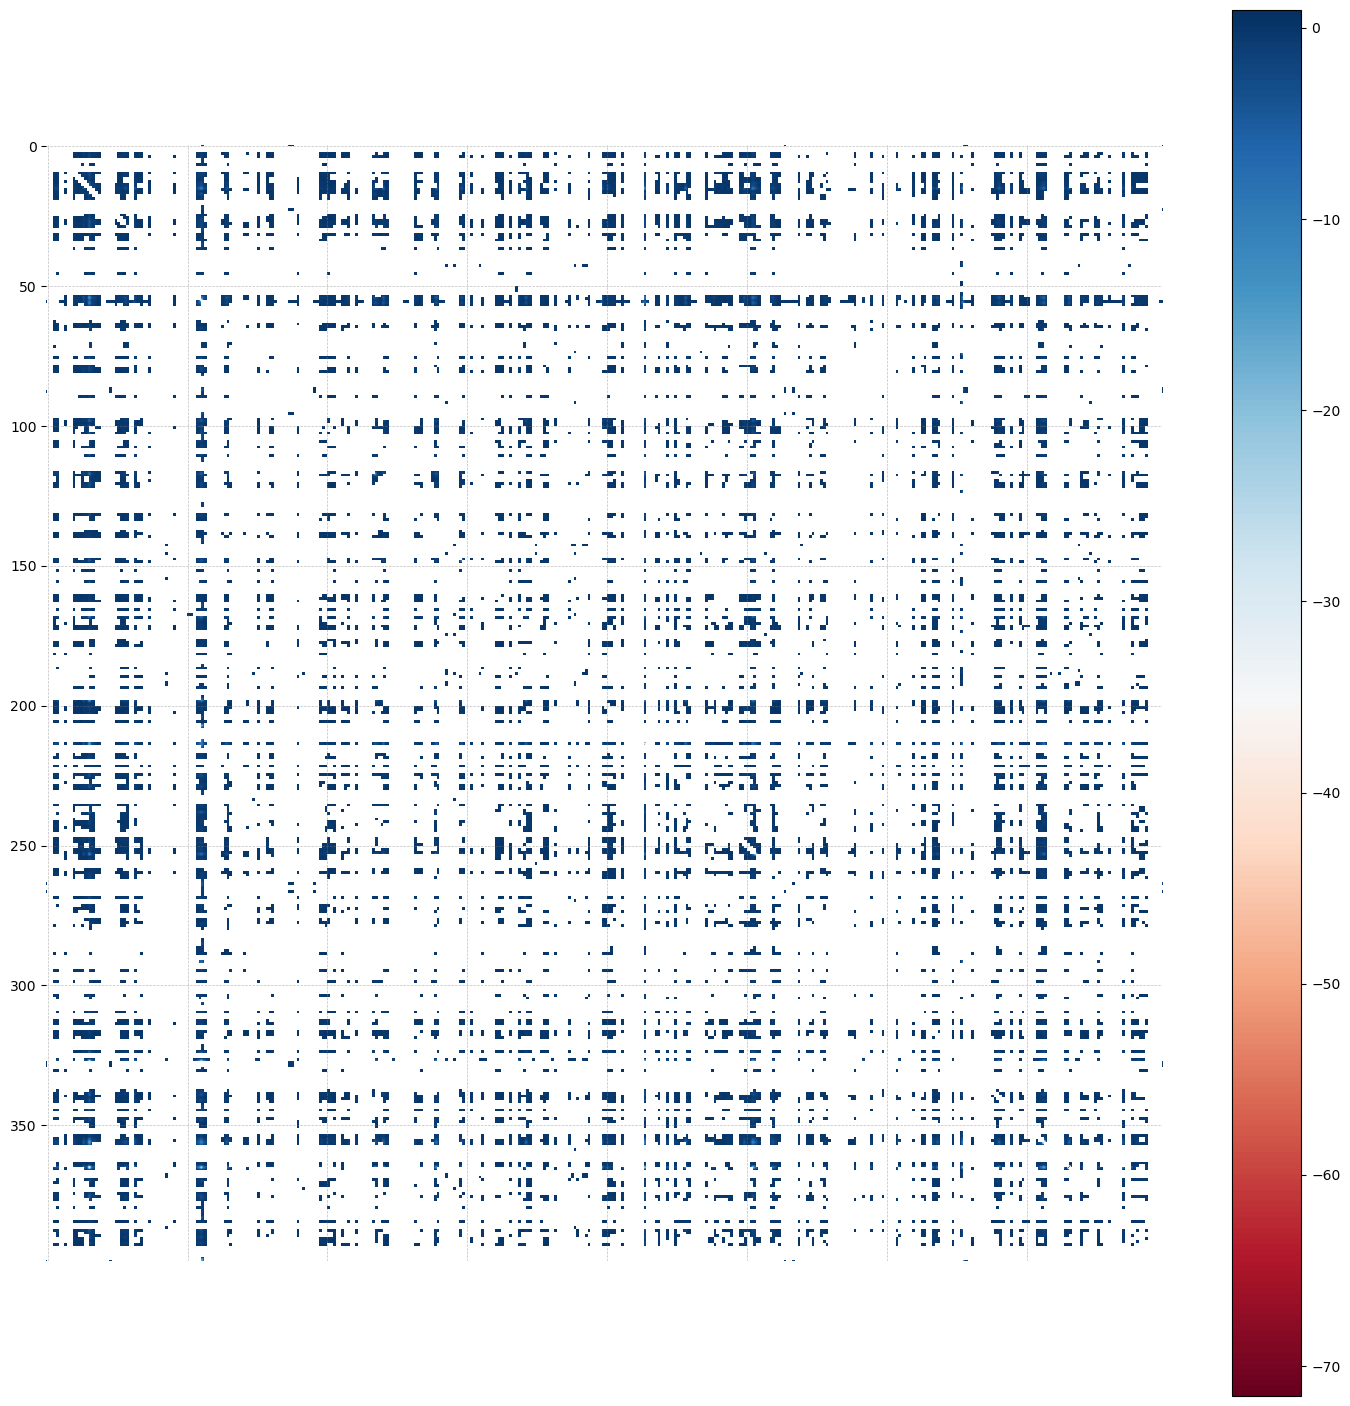

In [202]:
print_diff_mat(SB_1_mat,SB_0_mat)

In [205]:
get_max_min(SB_1_mat,SB_0_mat)

(-71.56020830901252, 0.9347562384216044)

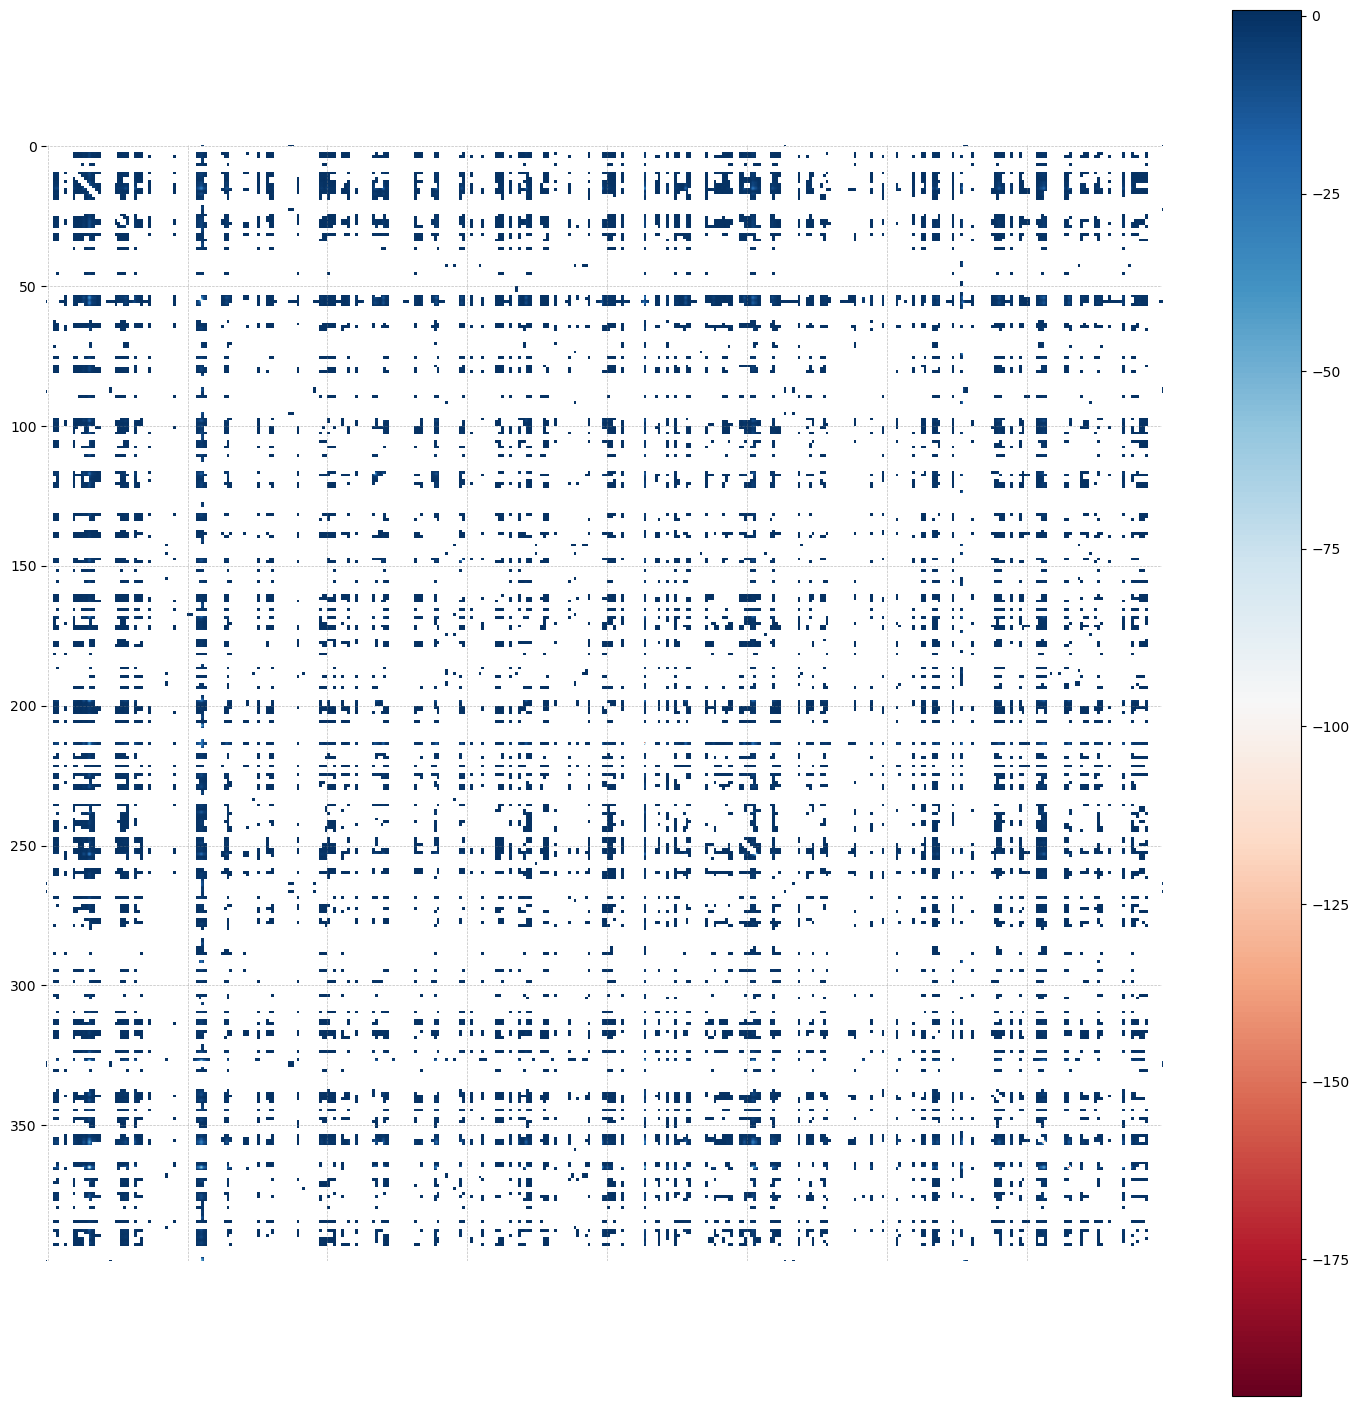

In [200]:
print_diff_mat(SB_2_mat,SB_0_mat)

In [206]:
get_max_min(SB_2_mat,SB_0_mat)

(-194.24234682649967, 0.834514085295913)

### IV.3  10

Discuss how the flows change for the 3 different situations: scenario A, and scenario B with two selections of parameters. Which scenario would have more impact in the redistribution of flows? Explain and justify your answers using the results of the analysis.     